In [37]:
import os
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

In [38]:
node_df = pd.read_csv("processed_data/node_attributes_file.csv")
edges_df = pd.read_csv("processed_data/edge_file.csv")
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")

# Task 1: Network Resilience

### Construct a network

*   Node: stations
*   Edge: trips between these stations (undirectional)
*   Edge weights: volume of trips

In [39]:
# Construct undirectional network datafile
edges_df_total = edges_df[['start_station_id', 'end_station_id', 'trip_count']].copy()
edges_df_total[['start_station_id', 'end_station_id']] = edges_df_total[['start_station_id', 'end_station_id']].astype(int)

# Sort the station IDs within each row to handle them as undirected edges
edges_df_total['min_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].min(axis=1)
edges_df_total['max_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].max(axis=1)

# Group by the sorted station IDs and sum the trip counts
undirectional_edges_df = edges_df_total.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

# Remove nodes where min = max
undirectional_edges_df = undirectional_edges_df[undirectional_edges_df.min_station_id != undirectional_edges_df.max_station_id]

In [ ]:
# undirectional_edges_df.to_csv("processed_data/total_edge_undirectional.csv", index = False)

In [40]:
# Construct undirectional network
min_nodes = undirectional_edges_df['min_station_id'].tolist()
max_nodes = undirectional_edges_df['max_station_id'].tolist()
weights = undirectional_edges_df['trip_count'].tolist()

g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")

Network Nodes: 773, Edges: 81754


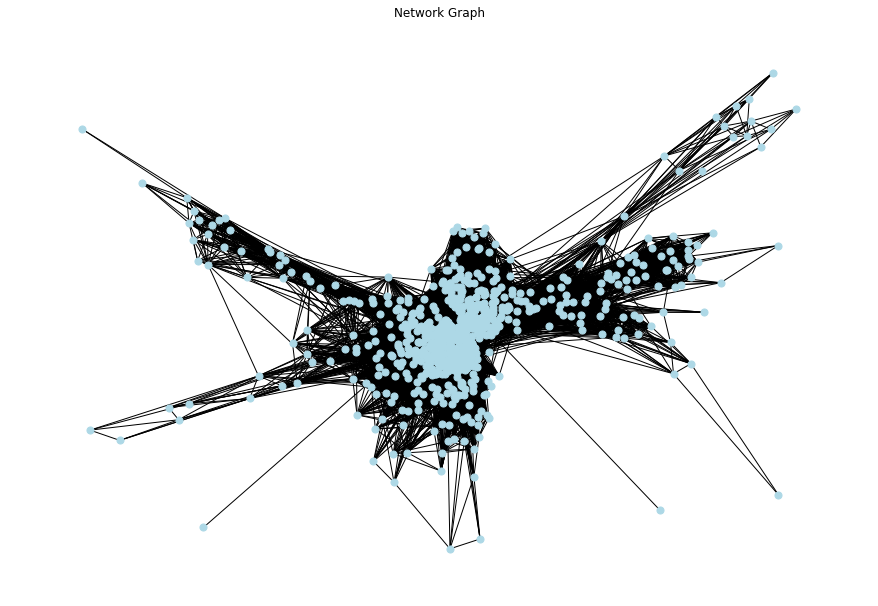

In [41]:
import networkx as nx
import scipy
import scipy.sparse

network_nx = nx.Graph(g.get_edgelist())
plt.figure(figsize=(12, 8))

nx.draw(network_nx, node_size=50, node_color='lightblue', with_labels=False)
plt.title('Network Graph')
plt.show()

In [ ]:
def draw_geographical_network(undirectional_edges_df):
    # Map the nodes based on geo location
    nodes = stations_geo_df.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)

    # Add edges with weights to the graph
    edges = undirectional_edges_df[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)

    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]

    degree_threshold = max_degree * 0.9

    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * 10 / max_weight for weight in weights]

    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}

    # Draw the network with improved visual parameters
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='deepskyblue', edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title('Network Graph Based on Geographical Locations')
    plt.axis('off')
    plt.show()

In [ ]:
draw_geographical_network(undirectional_edges_df)

### 1.1:
Implement the two types of node deletion strategies on your network, and plot the associated changes in average shortest path length (i.e., average distance) & diameter as a function of the fraction of nodes removed. Do the resulting plots resemble the Fig. 2 on Pg. 12 of the Albert et al. (2000) paper above? Why do you (/don’t you) see this pattern?

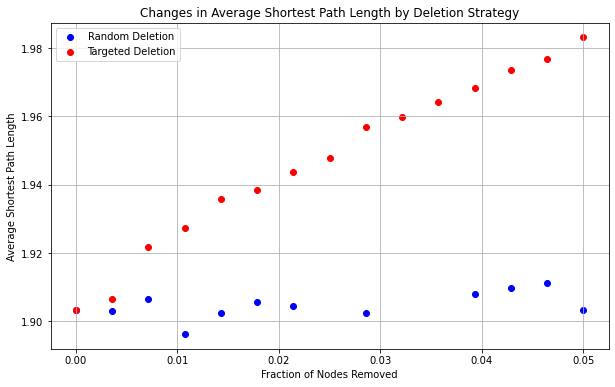

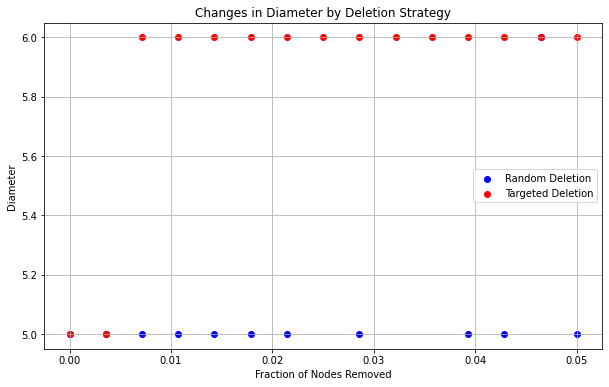

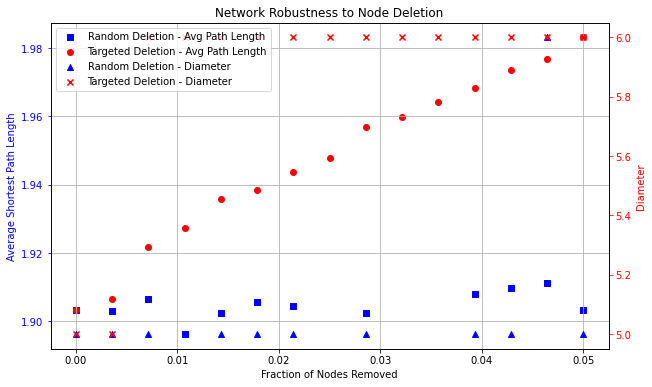

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

# Initialize lists to store results for plotting
fractions = np.linspace(0, 0.05, 15)  
random_avg_path_lengths = []
random_diameters = []
targeted_avg_path_lengths = []
targeted_diameters = []

# Define the random_node_deletion function
def random_node_deletion(network, fraction):
    num_nodes_to_remove = int(network.number_of_nodes() * fraction)
    nodes_to_remove = random.sample(list(network.nodes()), num_nodes_to_remove)
    network_copy = network.copy()
    network_copy.remove_nodes_from(nodes_to_remove)
    return network_copy

# Define the targeted_node_deletion function
def targeted_node_deletion(network, fraction):
    num_nodes_to_remove = int(network.number_of_nodes() * fraction)
    degrees = dict(network.degree())
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)[:num_nodes_to_remove]
    network_copy = network.copy()
    network_copy.remove_nodes_from(sorted_nodes)
    return network_copy

# Iterate over each fraction and perform deletions
for fraction in fractions:
    # Random node deletion
    random_network = random_node_deletion(network_nx, fraction)
    if nx.is_connected(random_network):
        random_avg_path_lengths.append(nx.average_shortest_path_length(random_network))
        random_diameters.append(nx.diameter(random_network))
    else:
        # Handle disconnected graph
        random_avg_path_lengths.append(None)
        random_diameters.append(None)

    # Targeted node deletion
    targeted_network = targeted_node_deletion(network_nx, fraction)
    if nx.is_connected(targeted_network):
        targeted_avg_path_lengths.append(nx.average_shortest_path_length(targeted_network))
        targeted_diameters.append(nx.diameter(targeted_network))
    else:
        # Handle disconnected graph
        targeted_avg_path_lengths.append(None)
        targeted_diameters.append(None)

# Plot the changes in average shortest path length using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fractions, random_avg_path_lengths, color='blue', label='Random Deletion')
plt.scatter(fractions, targeted_avg_path_lengths, color='red', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Shortest Path Length')
plt.title('Changes in Average Shortest Path Length by Deletion Strategy')
plt.legend()
plt.grid(True)
plt.show()

# Plot the changes in diameter using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fractions, random_diameters, color='blue', label='Random Deletion')
plt.scatter(fractions, targeted_diameters, color='red', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Diameter')
plt.title('Changes in Diameter by Deletion Strategy')
plt.legend()
plt.grid(True)
plt.show()

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter plot for average shortest path length
ax1.scatter(fractions, random_avg_path_lengths, color='blue', label='Random Deletion - Avg Path Length', marker='s')
ax1.scatter(fractions, targeted_avg_path_lengths, color='red', label='Targeted Deletion - Avg Path Length', marker='o')
ax1.set_xlabel('Fraction of Nodes Removed')
ax1.set_ylabel('Average Shortest Path Length', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis for diameter
ax2 = ax1.twinx()
ax2.scatter(fractions, random_diameters, color='blue', label='Random Deletion - Diameter', marker='^')
ax2.scatter(fractions, targeted_diameters, color='red', label='Targeted Deletion - Diameter', marker='x')
ax2.set_ylabel('Diameter', color='red')
ax2.tick_params('y', colors='red')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Title and grid
plt.title('Network Robustness to Node Deletion')
ax1.grid(True)

# Show plot
plt.show()

**1. Average Shortest Path Length:**

Targeted Attack: Both results show an increase in the average shortest path length under targeted deletion of nodes, which is expected because removing the most connected nodes disrupts the shortest paths. The difference in the magnitude of change could be due to differences in network size, topology, average degree.

Random Removal: In my results, the average shortest path length shows minor fluctuations, which suggests that the network has redundancy to withstand random failures without a significant impact on path lengths. This is similar to FIG.2 on Pg. 12 of the Albert et al. (2000), where there's also a minor increase. The common pattern is that random removals have less impact on the average shortest path length compared to targeted attacks, due to the lower likelihood of disrupting critical paths.

**2. Diameter:**

Targeted Attack: In my results, the diameter increases from 5 to 6 and then stabilizes. In FIG.2 on Pg. 12 of the Albert et al. (2000), the diameter increases significantly from 5 to 20. The pattern of an increase in diameter is consistent in both cases, illustrating that targeted attacks affect the network's diameter. The stabilization in my results could suggest that after a certain point, further removal of nodes doesn't create longer paths because the network becomes more fragmented or reaches a new structural equilibrium.

Random Removal: My results show that the diameter remains constant, while in FIG.2 , the diameter shows a slight increase. The constant diameter in my results suggests a high level of redundancy and robustness in my network, where random removals do not affect the longest shortest path between any two nodes. In FIG.2 , the increase, although slight, might indicate that the networks are less robust or that their longest paths are affected more by random removals.

Overall, the similarity in the patterns (increases under targeted attacks and smaller changes under random removals) aligns with established network theory, which suggests that networks are generally more robust against random failures than against targeted attacks. The differences in magnitude can be attributed to the specific characteristics of the networks being analyzed, including size, topology, and degree distribution. 

### 1.2
Can you think of any other important graph-level metric, apart from average distance or diameter, that can potentially measure structural resilience of the network to such errors and attacks? Compute this metric, and test if this metric also shows significant variation in response to these two types of node deletions.

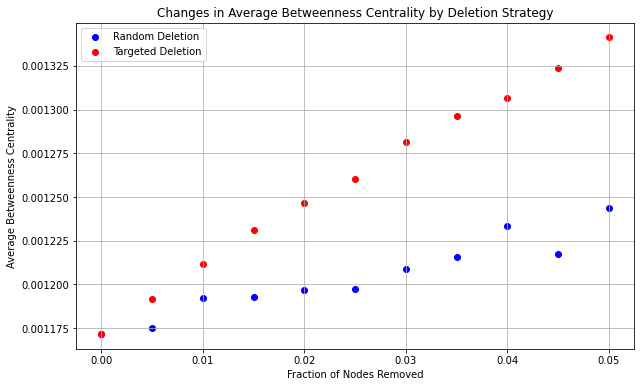

In [44]:
# Function to calculate average betweenness centrality of a network
def average_betweenness_centrality(network):
    betweenness = nx.betweenness_centrality(network)
    avg_betweenness = sum(betweenness.values()) / len(betweenness)
    return avg_betweenness

# Initialize lists to store results for plotting
fractions = np.linspace(0, 0.05, 11)  # From 0% to 5% in 0.5% steps
random_betweenness = []
targeted_betweenness = []

# Iterate over each fraction and perform deletions
for fraction in fractions:
    # Random node deletion
    random_network = random_node_deletion(network_nx, fraction)
    random_betweenness.append(average_betweenness_centrality(random_network))

    # Targeted node deletion
    targeted_network = targeted_node_deletion(network_nx, fraction)
    targeted_betweenness.append(average_betweenness_centrality(targeted_network))

# Plot the changes in betweenness centrality using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(fractions, random_betweenness, color='blue', label='Random Deletion')
plt.scatter(fractions, targeted_betweenness, color='red', label='Targeted Deletion')
plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Average Betweenness Centrality')
plt.title('Changes in Average Betweenness Centrality by Deletion Strategy')
plt.legend()
plt.grid(True)
plt.show()

Random Deletion (Blue Dots): The average betweenness centrality appears to remain relatively stable or increase slightly as nodes are randomly removed. This suggests that the network has some level of resilience against random failures. Since random deletions are unlikely to consistently remove the most central nodes (which contribute most to betweenness centrality), the overall impact on the network's betweenness centrality is limited.

Targeted Deletion (Red Dots): There is a clear upward trend in average betweenness centrality as more nodes are removed in a targeted fashion. This is expected because when you remove the most connected nodes, the number of shortest paths passing through the remaining nodes tends to increase. This happens because the removal of central nodes forces the network's traffic to reroute through fewer remaining pathways, thus increasing the load (and hence the betweenness centrality) on those nodes.

From the analysis, it's evident that the network responds differently to errors and attacks:

Structural Resilience to Errors: The network's structure is not significantly perturbed by random failures, indicating a level of robustness or redundancy in connectivity that prevents any single node's failure from having a disproportionate effect.

Vulnerability to Attacks: In contrast, the network is more vulnerable to attacks that target the most connected nodes. The increase in betweenness centrality indicates that such attacks can effectively centralize the network traffic on fewer nodes, potentially creating bottlenecks that can hinder the network's functionality.

Overall, the betweenness centrality metric provides insight into the network's flow dynamics and highlights potential vulnerabilities to targeted attacks. It shows that while the network might be robust against random errors, it is more susceptible to intentional attacks that target its most connected nodes. This analysis can be crucial for designing strategies to protect the network against such vulnerabilities.

### 1.3
Repeat the above set of analyses for the network over time (e.g., for each month or quarter or year). Do you see any change in the resilience of the network over time? What patterns (if any) do you see from this temporal analysis?

1.3.1. Create Network for each month

In [45]:
#construct monthly network (node_df,edges_df,)
edges_df['date']= edges_df['year'].astype(str)+ edges_df['month'].astype(str)
edges_df['date']= edges_df['date'].astype(int)
network_monthly={}
for month in edges_df['date'].unique():
    edges_df_month = edges_df[edges_df['date'] == month][['date','start_station_id', 'end_station_id', 'trip_count']].copy()
    edges_df_month[['start_station_id', 'end_station_id']] = edges_df_month[['start_station_id', 'end_station_id']].astype(int)

    # Sort the station IDs within each row to handle them as undirected edges
    edges_df_month['min_station_id'] = edges_df_month[['start_station_id', 'end_station_id']].min(axis=1)
    edges_df_month['max_station_id'] = edges_df_month[['start_station_id', 'end_station_id']].max(axis=1)
    # Group by the sorted station IDs and sum the trip counts
    undirectional_edges_df_month = edges_df_month.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

    # Remove nodes where min = max
    undirectional_edges_df_month = undirectional_edges_df_month[undirectional_edges_df_month.min_station_id != undirectional_edges_df_month.max_station_id]

    # Construct undirectional network
    min_nodes = undirectional_edges_df_month['min_station_id'].tolist()
    max_nodes = undirectional_edges_df_month['max_station_id'].tolist()
    weights = undirectional_edges_df_month['trip_count'].tolist()

    g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

    network_monthly[month]=g

In [ ]:
print(network_monthly)

In [46]:
no_edges=0
for month, g in network_monthly.items():
    print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")
    no_edges = no_edges+ len(g.es)
print(no_edges)

Network Nodes: 714, Edges: 28402
Network Nodes: 718, Edges: 29594
Network Nodes: 722, Edges: 34409
Network Nodes: 729, Edges: 40929
Network Nodes: 728, Edges: 43208
Network Nodes: 735, Edges: 42343
Network Nodes: 739, Edges: 42530
Network Nodes: 738, Edges: 42614
Network Nodes: 738, Edges: 42304
Network Nodes: 745, Edges: 42868
Network Nodes: 755, Edges: 36644
Network Nodes: 758, Edges: 32285
Network Nodes: 759, Edges: 29053
487183


1.3.2 Node Deletion and Network Resilience over 13 Months 

In [47]:
monthly_results = {}

for month, g_month in network_monthly.items():
    network = nx.Graph(g_month.get_edgelist())
    random_avg_path_lengths = []
    random_diameters = []
    random_betweenness = []
    targeted_avg_path_lengths = []
    targeted_diameters = []
    targeted_betweenness = []
    # Iterate over each fraction and perform deletions
    for fraction in fractions:
        # Random node deletion
        random_network = random_node_deletion(network, fraction)
        if nx.is_connected(random_network):
            random_avg_path_lengths.append(nx.average_shortest_path_length(random_network))
            random_diameters.append(nx.diameter(random_network))
            random_betweenness.append(average_betweenness_centrality(random_network))
        else:
            # Handle disconnected graph
            random_avg_path_lengths.append(None)
            random_diameters.append(None)
            random_betweenness.append(None)

        #Targeted node deletion
        targeted_network = targeted_node_deletion(network, fraction)
        if nx.is_connected(targeted_network):
            targeted_avg_path_lengths.append(nx.average_shortest_path_length(targeted_network))
            targeted_diameters.append(nx.diameter(targeted_network))
            targeted_betweenness.append(average_betweenness_centrality(targeted_network))
        else:
            # Handle disconnected graph
            targeted_avg_path_lengths.append(None)
            targeted_diameters.append(None)
            targeted_betweenness.append(None)

    monthly_results[month]= {'random_avg_path_lengths': random_avg_path_lengths,
        'random_diameters': random_diameters,
        'random_betweenness':random_betweenness,
        'targeted_avg_path_lengths': targeted_avg_path_lengths,
        'targeted_diameters': targeted_diameters,
        'targeted_betweenness':targeted_betweenness
    }



In [ ]:
for month, results in monthly_results.items():
    # Unpack the results dictionary for the current month
    random_avg_path_lengths = results['random_avg_path_lengths']
    targeted_avg_path_lengths = results['targeted_avg_path_lengths']
    random_diameters = results['random_diameters']
    targeted_diameters = results['targeted_diameters']
    random_betweenness = results['random_betweenness']
    targeted_betweenness = results['targeted_betweenness']

    # Create a figure and a single subplot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Scatter plot for average shortest path length
    ax1.scatter(fractions, random_avg_path_lengths, color='blue', label='Random Deletion - Avg Path Length', marker='s')
    ax1.scatter(fractions, targeted_avg_path_lengths, color='red', label='Targeted Deletion - Avg Path Length', marker='o')
    ax1.set_xlabel('Fraction of Nodes Removed')
    ax1.set_ylabel('Average Shortest Path Length', color='blue')
    ax1.tick_params('y', colors='blue')

    # Create a second y-axis for diameter
    ax2 = ax1.twinx()
    ax2.scatter(fractions, random_diameters, color='green', label='Random Deletion - Diameter', marker='^')
    ax2.scatter(fractions, targeted_diameters, color='orange', label='Targeted Deletion - Diameter', marker='x')
    ax2.set_ylabel('Diameter', color='green')
    ax2.tick_params('y', colors='green')

    # Create a third y-axis for betweenness
    ax3 = ax1.twinx()
    ax3.scatter(fractions, random_betweenness, color='purple', label='Random Deletion - Betweenness', marker='d')
    ax3.scatter(fractions, targeted_betweenness, color='cyan', label='Targeted Deletion - Betweenness', marker='*')
    ax3.set_ylabel('Betweenness', color='purple')
    ax3.tick_params('y', colors='purple')

    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')

    # Title and grid
    plt.title(f'Network Robustness to Node Deletion for {month}')
    ax1.grid(True)

    # Show plot
    plt.show()


In [ ]:
# for each quarter 
edges_df['quarter'] = ((edges_df['year'] - 2023) * 4 + (edges_df['month']) // 3) + 1
network_quarterly={}
for quarter in edges_df['quarter'].unique():
    edges_df_quarter = edges_df[edges_df['date'] == quarter][['date','start_station_id', 'end_station_id', 'trip_count']].copy()
    edges_df_quarter[['start_station_id', 'end_station_id']] = edges_df_quarter[['start_station_id', 'end_station_id']].astype(int)

    # Sort the station IDs within each row to handle them as undirected edges
    edges_df_quarter['min_station_id'] = edges_df_quarter[['start_station_id', 'end_station_id']].min(axis=1)
    edges_df_quarter['max_station_id'] = edges_df_quarter[['start_station_id', 'end_station_id']].max(axis=1)
    # Group by the sorted station IDs and sum the trip counts
    undirectional_edges_df_quarter = edges_df_quarter.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

    # Remove nodes where min = max
    undirectional_edges_df_quarter = undirectional_edges_df_quarter[undirectional_edges_df_quarter.min_station_id != undirectional_edges_df_quarter.max_station_id]

    # Construct undirectional network
    min_nodes = undirectional_edges_df_quarter['min_station_id'].tolist()
    max_nodes = undirectional_edges_df_quarter['max_station_id'].tolist()
    weights = undirectional_edges_df_quarter['trip_count'].tolist()

    g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

    network_quarterly[quarter]=g

In [ ]:
no_edges=0
for quarter, g in network_quarterly.items():
    print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")
    no_edges = no_edges+ len(g.es)
print(no_edges)

In [ ]:
quarterly_results = {}

for quarter, g_quarter in network_quarterly.items():
    network = nx.Graph(g_quarter.get_edgelist())
    random_avg_path_lengths = []
    random_diameters = []
    random_betweenness = []
    targeted_avg_path_lengths = []
    targeted_diameters = []
    targeted_betweenness = []
    # Iterate over each fraction and perform deletions
    for fraction in fractions:
        # Random node deletion
        random_network = random_node_deletion(network, fraction)
        if nx.is_connected(random_network):
            random_avg_path_lengths.append(nx.average_shortest_path_length(random_network))
            random_diameters.append(nx.diameter(random_network))
            random_betweenness.append(average_betweenness_centrality(random_network))
        else:
            # Handle disconnected graph
            random_avg_path_lengths.append(None)
            random_diameters.append(None)
            random_betweenness.append(None)

        #Targeted node deletion
        targeted_network = targeted_node_deletion(network, fraction)
        if nx.is_connected(targeted_network):
            targeted_avg_path_lengths.append(nx.average_shortest_path_length(targeted_network))
            targeted_diameters.append(nx.diameter(targeted_network))
            targeted_betweenness.append(average_betweenness_centrality(targeted_network))
        else:
            # Handle disconnected graph
            targeted_avg_path_lengths.append(None)
            targeted_diameters.append(None)
            targeted_betweenness.append(None)

    quarterly_results[quarter]= {'random_avg_path_lengths': random_avg_path_lengths,
        'random_diameters': random_diameters,
        'random_betweenness':random_betweenness,
        'targeted_avg_path_lengths': targeted_avg_path_lengths,
        'targeted_diameters': targeted_diameters,
        'targeted_betweenness':targeted_betweenness
    }

